#FRETBursts - us-ALEX smFRET burst analysis

*This notebook is part of a [tutorial series](https://github.com/tritemio/FRETBursts_notebooks) for the [FRETBursts](http://tritemio.github.io/FRETBursts/) burst analysis software.*

> In this notebook we present a typical [FRETBursts](https://github.com/tritemio/FRETBursts/) 
> workflow for **us-ALEX smFRET burst analysis**. 
> Briefly, we show how to perform background estimation, burst search, burst selection, 
> FRET histograms, ALEX histograms, sub-population selection and FRET efficiency fit.

# Loading the software

We start loading **`FRETBursts`**:

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
-------------------------------------------------------------
 You are running FRETBursts (version 0.4).

 If you use this software in a publication, please cite it as:

   FRETBursts - An opensource single-molecule FRET bursts analysis toolkit.
   A. Ingargiola 2014. https://github.com/tritemio/FRETBursts

-------------------------------------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


> *Please remember to **always cite** FRETBursts in publications or presentations.*

Note that FRETBursts **version string** tells you the exact revision that is currently in use (we use [versioneer](https://github.com/warner/python-versioneer)). Storing the version in the notebook helps reproducibility and in tracking software regressions.

Optionally we can initialize the default plot style for the notebook (requires [seaborn](http://stanford.edu/~mwaskom/software/seaborn/)):

In [2]:
sns = init_notebook()

In [3]:
import lmfit; lmfit.__version__

'0.8.3'

In [4]:
import phconvert; phconvert.__version__

'0.4.7'

#Downloading the sample data file

The full list of smFRET measurements used in the [FRETBursts tutorials](https://github.com/tritemio/FRETBursts_notebooks) 
can be found on [Figshare](http://dx.doi.org/10.6084/m9.figshare.1019906).

Here we download the us-ALEX data-file and put it in a folder named `data`, inside the notebook folder. 
For this purpose we use the `download_file` function provided by FRETBursts:

In [5]:
url = 'http://files.figshare.com/2040497/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

In [6]:
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2040497/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: C:\Data\Antonio\software\src\fretbursts\notebooks\data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


# Selecting a data file

Let's select now a data-file. We can either paste the filename in a variable, or we can use a GUI Open-File dialog. In either cases we'll end up with the a file-name stored in the variable `full_fname`.

## Option 1: Use an "Open File" dialog

We can select a data file with an "Open File" windows (note: it may pop-up in the foreground):

In [7]:
# filename = OpenFileDialog()
# filename

Now `full_fname` contains the path of the file you just selected. Run again the previous cell to select a new file.

##Option 2: Paste the file-name

Alternatively, we can directly define the file name to be loaded:

In [8]:
filename = "./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"

Let's check that the file exists:

In [9]:
import os
if os.path.isfile(filename):
    print("Perfect, I found the file!")
else:
    print("Sorry, I can't find the file:\n%s" % filename)

Perfect, I found the file!


# Load the selected file

We can finally load the measurement and store it in a variable called (go figure) `d`. 

For convenience we also set the correction coefficients so that they will be used in the subsequent analysis. The correction coefficients are: 

* leakage or bleed-through: `leakage`
* direct excitation: `dir_ex` (ALEX-only)
* gamma-factor `gamma`

In [10]:
d = loader.photon_hdf5(filename)

In [11]:
d.leakage = 0.11
d.dir_ex = 0.04
d.gamma = 1.

> **NOTE:** at any later moment, after burst search, a simple reassignment of these coefficient will update the burst data with the new correction values.

# us-ALEX parameters

At this point, in `d`, we only have the timestamps (`ph_times_t`) and the detector numbers (`det_t`):

In [12]:
d.ph_times_t, d.det_t

(array([     146847,      188045,      294124, ..., 47999863658,
        47999877783, 47999955353], dtype=int64),
 array([0, 1, 1, ..., 1, 1, 0], dtype=uint32))

We need to define some ALEX parameters: 

- donor and acceptor channels (`det_donor_accept`)
- length of excitation period (`alex_period`)
- donor and acceptor excitation windows (`D_ON` and `A_ON`)

In [13]:
d.add(det_donor_accept=(0, 1), alex_period=4000, D_ON=(2850, 580), A_ON=(900, 2580))

We have to check the consistency of the alternation histogram to verify whether the parameters are correct:

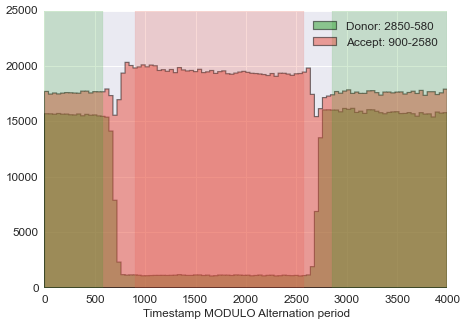

In [14]:
bpl.plot_alternation_hist(d)

The previous alternation histogram looks correct, so we can apply the current parameters:

In [15]:
loader.alex_apply_period(d)

#donor: 727353  #acceptor: 1579968 



If the previous histogram does not look right, you can go back and modify the parameters in the `d.add(...)` cell and re-plot the histogram until it looks fine. Don't forget to apply the parameters with `loader.usalex_apply_period(d)` as a last step.

> **NOTE:** After applying the ALEX parameters a new array of timestamps containing only photons inside the excitation periods is created (name `d.ph_times_m`). To save memory, by default, the old timestamps array (`d.ph_times_t`) is deleted. Therefore, in the following, when we talk about all-photon selection we always refer to all photons inside the excitation periods.

##Measurement infos

The entire measurement data is now in the variable `d`. Printing it will give a compact representation containing the file-name and some eventual parameters (only the $\gamma$-factor in this case):

In [16]:
d

data_0023uLRpitc_NTP_20dT_0.5GndCl G1.000 Lk0.110 dir4.0

To check the **measurement duration** run:

In [17]:
d.time_max

599.99944191249995

# Background estimation

As a first step of the analysis we need to estimate the background. The assumption is that the background is a Poisson process and therefore the photon waiting times are exponentially distributed. Since the background can change during the measurement a new estimation is computed every `time_s` seconds (this time is called the *background period*).

A problem is that in the photon waiting times distribution we have both signal and background. Therefore we need to choose a threshold to discriminate between the exponential tail from the rest.

Choosing a threshold and fitting the exponential tail are two different problems.
FRETBursts provides several ways to specify the minimum threshold and different functions to fit the exponential tail.

You can find more info in the documentation for [`calc_bg()` method](http://fretbursts.readthedocs.org/en/latest/data_class.html#fretbursts.burstlib.Data.calc_bg), 
the [`background` module](http://fretbursts.readthedocs.org/en/latest/background.html)
and [`exp_fitting` module](http://fretbursts.readthedocs.org/en/latest/background.html#module-fretbursts.fit.exp_fitting).

## Single threshold

Let start with a standard Maximum Likelihood (ML) background fit with a minimum tail threshold of 500us:

In [18]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us=500)

 - Calculating BG rates ... [DONE]


We can look how the fit looks with:

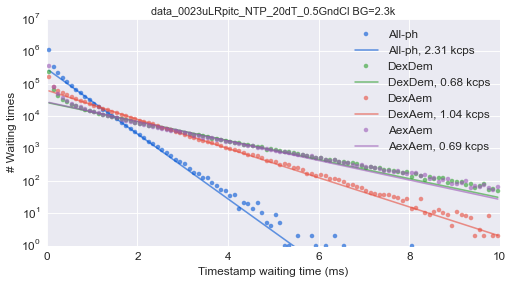

In [19]:
dplot(d, hist_bg, show_fit=True)

## Multiple thresholds

Optionally, we can specify a threshold for each channel to obtain a better fit:

In [20]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us=(800, 4000, 1500, 1000, 3000))

 - Calculating BG rates ... [DONE]


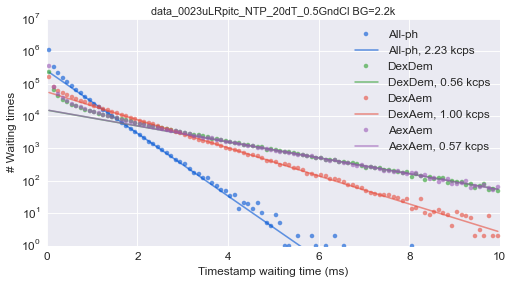

In [21]:
dplot(d, hist_bg, show_fit=True)

## Automatic threshold

Finally, is possible to let FRETBursts infer the threshold automatically with:

In [22]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


this is the recommended approach.

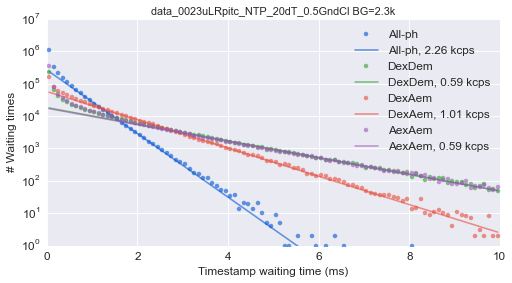

In [23]:
dplot(d, hist_bg, show_fit=True)

## Background timetrace

In [24]:
d.calc_bg(bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


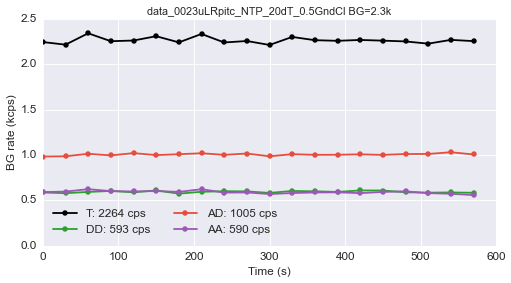

In [25]:
dplot(d, timetrace_bg)

##Getting the background rates

The background rates are stored in `Data()` attributes `bg`, `bg_dd`, `bg_ad`, `bg_aa`. These contain all the fitted background rates for each channel and period.

We can also get the average background for each channel:

In [26]:
d.rate_m, d.rate_dd, d.rate_ad, d.rate_da, d.rate_aa

([2264.1218163988983],
 [593.25462479647081],
 [1005.3753942115378],
 [77.994303199673524],
 [590.27174419583059])

#Burst analysis

First step of burst analysis is the burst search. 

We'll use the sliding-window algorithm on all photons. Note that all-photons here means all the photons selected in the alternation histogram.
An important variation compared to the classical sliding-windows is that the threshold-rate for burst start is computed as a function of the background and it changes when the background changes during the measurement.

Let perfom a burst search evaluating the photon rate with 10 photons (`m=10`), and selecting a minimum rate 6 times the background rate (F=6) on all photons (default):

In [27]:
d.burst_search(L=10, m=10, F=6)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]


The previous command perfoms the burst search, corrects the bursts sizes for background and spectral leakage,
applies the gamma correction and compute FRET and Stoichiometry. See the 
[`burst_search` documentation](http://fretbursts.readthedocs.org/en/latest/data_class.html#fretbursts.burstlib.Data.burst_search) for more details.

We can plot the resulting FRET histogram like this:

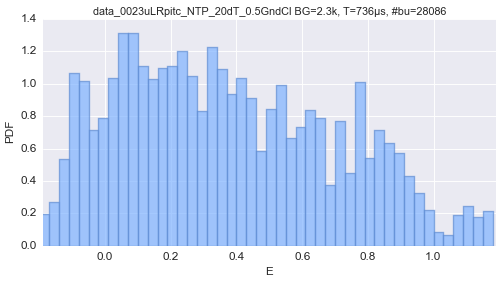

In [28]:
dplot(d, hist_fret);

All the pre-defined plots follow this pattern: 
call the generic `dplot()` function, passing 2 parameters:

- the measurement data (`d` in this case) 
- the plot function (`hist_fret`)

In some case we can add other optional parameters to tweak the plot.

All the plot functions start with `hist_` for histograms, `scatter_` for scatter-plots  or `timetrace_` for plots function of measurement time. You can use autocompletion to find all the plot function or you can look in `bursts_plot.py` where all the plot functions are defined.

Instead of `hist_fret` we can use `hist_fret_kde` to add a [KDE](http://en.wikipedia.org/wiki/Kernel_density_estimation) overlay. Also, we can plot a **weighted histogram** by passing an additional parameter `weights`:

 - Overwriting the old E_fitter object with the new weights.


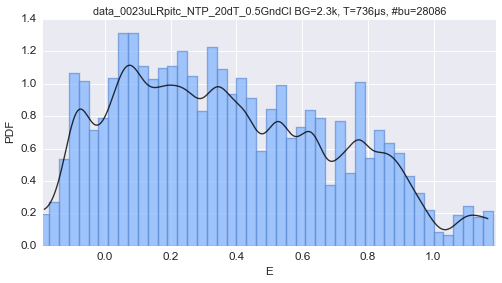

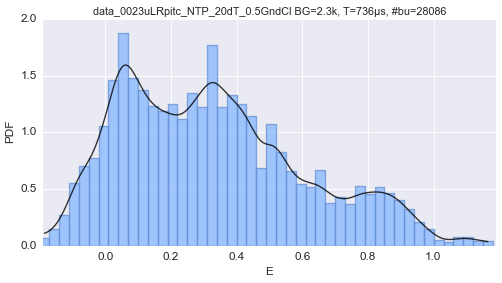

In [29]:
dplot(d, hist_fret, show_kde=True);
dplot(d, hist_fret, show_kde=True, weights='size');

You can experiment with different weighting schema (for all supported weights see `get_weigths()` function in `fret_fit.py`).

## Burst selection

When performing the burst search we specified `L=10` without explaining what it is. *L* is traditionally the minimum size (number of photons) for a burst: smaller bursts will be rejected. By setting L=m (10 in this case) we are deciding to don't discard any burst  (because the smallest detected burst has at least *m* counts). 

Selecting the bursts in a second step considering the corrected burst size, results in a more accurate an un-biased selection.

For example we can select bursts with more than 30 photons (after background, gamma and leakage corrections) and store the result in a new `Data()` variable `ds`:

In [30]:
ds = d.select_bursts(select_bursts.size, th1=30)

By defaults the burst size includes donor and acceptor photons during donor excitation. To also add acceptor photons during acceptor excitation (`naa`) we can pass `add_naa=True`:

In [31]:
ds = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

Similar to the plot functions, all the selection functions are defined in `select_bursts.py` and you can access them typing `select_bursts.` and using TAB for autocompletion. 

> **See also:** 
> * [Burst selection](http://fretbursts.readthedocs.org/en/latest/burst_selection.html) in the documentation. 
> In particular the function [`select_bursts.size`](http://fretbursts.readthedocs.org/en/latest/burst_selection.html#fretbursts.select_bursts.size) and [`Sel`](http://fretbursts.readthedocs.org/en/latest/burst_selection.html#fretbursts.burstlib.Sel).

Let's replot the FRET histogram after selection (note that now we are passing `ds` that contains the selected bursts):

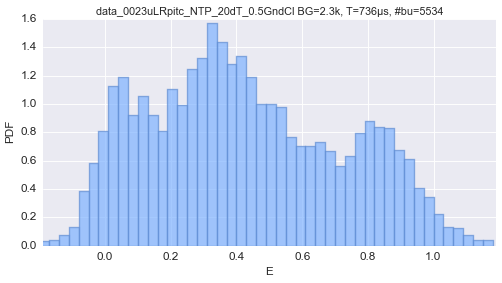

In [32]:
dplot(ds, hist_fret);

Note how the histogram is much more defined after the burst selection. 

## Histogram fitting and plotting style

Under the hood the previous `hist_fret` plot creates a `MultiFitter` object for $E$ values. This object, stored as `ds.E_fitter`, operates on multi-channel data and computes the histogram, KDE and can fit the histogram with a model ([lmfit.Model](http://lmfit.github.io/lmfit-py/model.html)).

Now, as just an example, we fit the histogram with 3 Gaussian peaks, using the already created `ds.E_fitter` object:

In [33]:
ds.E_fitter.fit_histogram(mfit.factory_three_gaussians())

 - Adding parameter "p3_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"


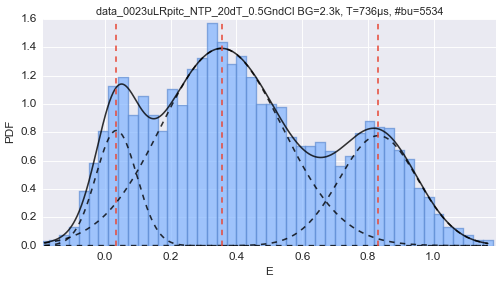

In [34]:
dplot(ds, hist_fret, show_model=True)

The bin width can be changed with `binwidth` argument or the full bins can be passed in `bins` (overriding `binwidth`).

We can customize the appearance of this plot (type `hist_fret?` for the complete set of arguments). 

For example to change from a bar plot to a line-plot we use the `hist_style` argument:

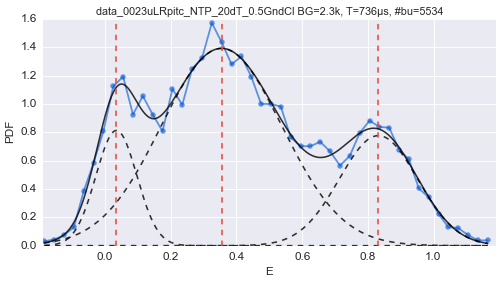

In [35]:
dplot(ds, hist_fret, show_model=True, hist_style='line')

We can customize the line-plot, bar-plot, the model plot and the KDE plot by passing dictionaries with matplotlib style. The name of the arguments are:

- `hist_plot_style`: style fot the histogram line-plot
- `hist_bar_style`: style for the histogram bar-plot
- `model_plot_style`: style for the model plot
- `kde_plot_style`: style for the KDE plot

Let see an example:

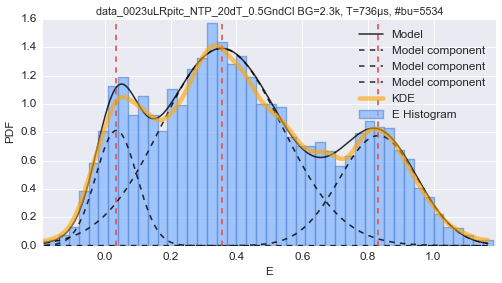

In [36]:
dplot(ds, hist_fret, show_model=True, hist_style='bar', show_kde=True,
      kde_plot_style = dict(linewidth=5, color='orange', alpha=0.6),
      hist_plot_style = dict(linewidth=3, markersize=8, color='b', alpha=0.6))
plt.legend()

# Other plots

Similarly we can plot the burst size using all photons (type `hist_size?` for all the plot options):

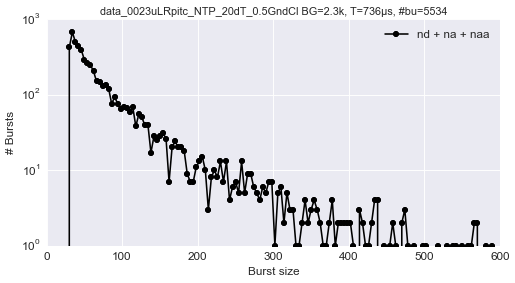

In [37]:
dplot(ds, hist_size, add_naa=True);

Or plot the burst size histogram for the different components:

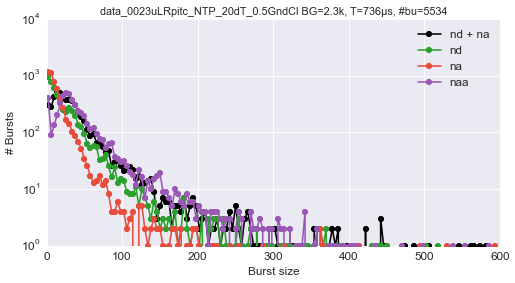

In [38]:
dplot(ds, hist_size_all);

> **NOTE:** The previous plot may generate a benign warning due to the presence of zeroes when switching to log scale. Just ignore it.

A scatterplot Size *vs* FRET:

(-1, 2)

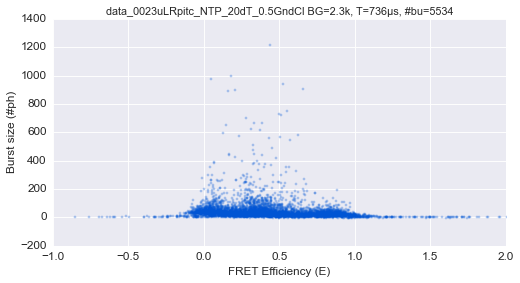

In [39]:
dplot(ds, scatter_fret_nd_na)
xlim(-1, 2)

# Study of different populations

We can further select only bursts smaller than 300 photons to get rid of eventual aggregates:

In [40]:
ds2 = ds.select_bursts(select_bursts.size, th2=300)

and superimpose the two histograms before and after selection to see the difference:

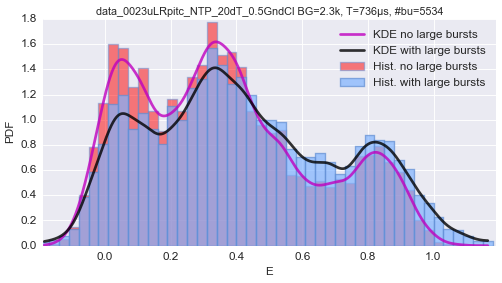

In [41]:
ax = dplot(ds2, hist_fret, hist_style='bar', show_kde=True, 
              hist_bar_style = dict(facecolor='r', alpha=0.5, label='Hist. no large bursts'),
              kde_plot_style = dict(lw=3, color='m', label='KDE no large bursts'))
dplot(ds, hist_fret, ax=ax, hist_style='bar', show_kde=True,
      hist_bar_style = dict(label='Hist. with large bursts'),
      kde_plot_style = dict(lw=3, label='KDE with large bursts'))
plt.legend();

## Fit and plot peak positions

We can find the KDE peak position in a range (let say 0.2 ... 0.6):

In [42]:
ds.E_fitter.find_kde_max(np.r_[0:1:0.0002], xmin=0.2, xmax=0.6)

and plot it with `show_kde_peak=True`, we also use `show_fit_value=True` to show a box with the fitted value:

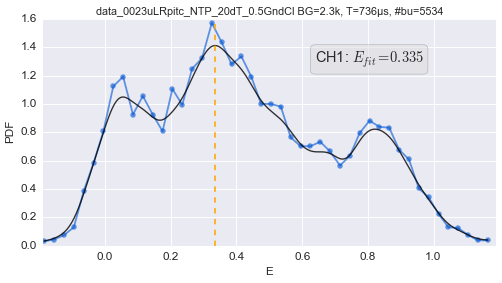

In [43]:
dplot(ds, hist_fret, hist_style='line', 
      show_fit_value=True, 
      show_kde=True, show_kde_peak=True);

Instead of using the KDE, we can use the peak position as fitted from a gaussian model. 

In [44]:
ds.E_fitter.fit_histogram(mfit.factory_three_gaussians())

 - Adding parameter "p3_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"


To select which peak to show we use `fit_from='p1_center'`:

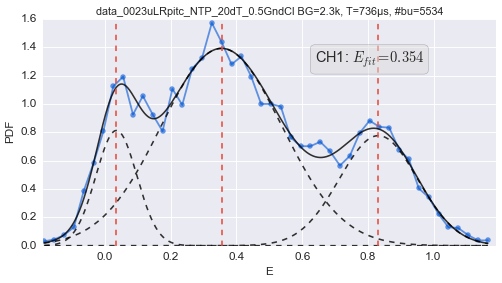

In [45]:
dplot(ds, hist_fret, hist_style='line', 
      show_fit_value=True, fit_from='p1_center', 
      show_model=True);

The string `'p1_center'` is the name of the parameter of the gaussian fit that we want to show in the text box. To see all the parameters of the models we look in:

In [46]:
ds.E_fitter.params

,p3_amplitude,p2_center,p3_center,p1_sigma,p1_center,p2_amplitude,p2_sigma,p3_sigma,p1_amplitude
0,0.1271674,0.8320838,0.03453634,0.1836772,0.3544727,0.2318743,0.1191219,0.06240628,0.6411093


## ALEX plots

We can make a simple E-S scatter plot with `scatter_alex`:

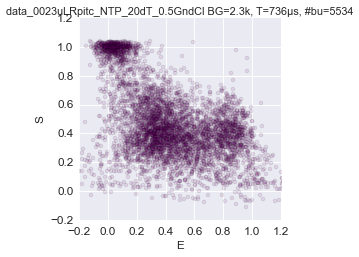

In [47]:
dplot(ds, scatter_alex, figsize=(4,4), mew=1, ms=4, mec='black', color='purple')

We can also plot the ALEX histogram with a scatterplot overlay using `hist2d_alex`:

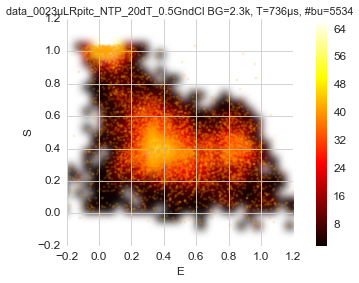

In [48]:
dplot(ds, hist2d_alex);

Finally we can also plot an ALEX histogram and marginals (joint plot) as follow (for more options see: [Example - usALEX histogram](Example - usALEX histogram.ipynb)):

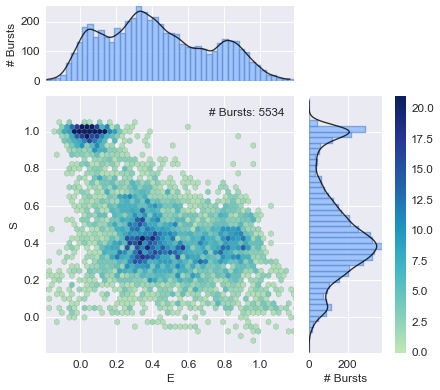

In [49]:
alex_jointplot(ds)

We can try get rid of the large donor-only population simply selecting burst with at least 4 photons in the acceptor channel (during acceptor excitation):

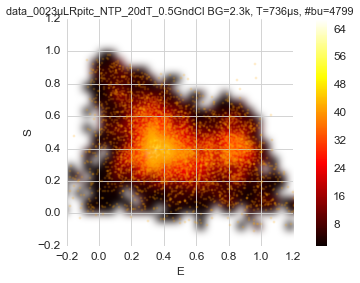

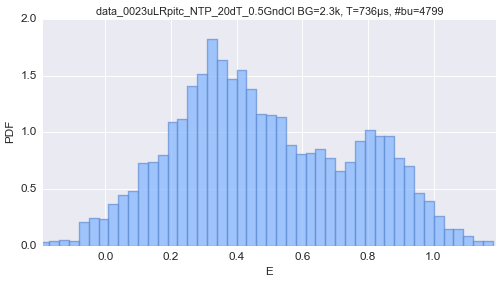

In [50]:
ds2 = ds.select_bursts(select_bursts.naa, th1=4)
dplot(ds2, hist2d_alex);
dplot(ds2, hist_fret);

Much better, but maybe we want to select a region on the E/S histogram to completely eliminate the donor-only.

To select bursts graphically we need to open the ALEX histogram in a new (QT) window, dragg the mouse to define a selection and  having it printed here in the notebook.

When you are done you can close the additional window and continue the execution.

Here the commands:

In [51]:
# Switches to open plot in external window
#%matplotlib qt 

In [52]:
plt.close('all')

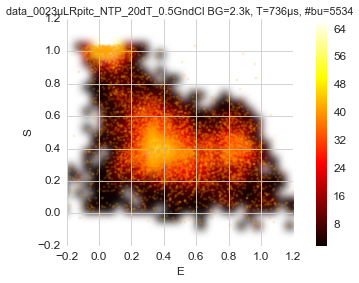

In [53]:
# ALEX histogram with GUI selection enabled
dplot(ds, hist2d_alex, gui_sel=True)

In [54]:
# Switch back to show plots inline in the notebook
#%matplotlib inline

Now, to apply the selection, we paste the values obtained from the previous plot. We can use a rectangular or elliptical selection (see image), using `select_bursts.ES` and setting respectively `rect=True` or `rect=False`. Here we use the ellitpical selection:

In [55]:
d_fret_mix = ds.select_bursts(select_bursts.ES, E1=-0.07, E2=1.17, S1=0.18, S2=0.70, rect=False)

By plotting the FRET histogram we can double check that the selection has been applied:

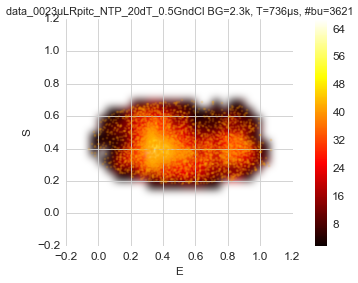

In [56]:
dplot(d_fret_mix, hist2d_alex)

Now we can further separate high- and low FRET sub-populations. We can go back to the GUI:

In [57]:
#%matplotlib qt

In [58]:
#dplot(d_fret_mix, hist2d_alex, gui_sel=True)

In [59]:
#%matplotlib inline

In [60]:
d_high_fret = d_fret_mix.select_bursts(select_bursts.ES_ellips, E1=0.65, E2=1.09, S1=-0.13, S2=0.96)
d_low_fret = d_fret_mix.select_bursts(select_bursts.ES_ellips, E1=-0.19, E2=0.64, S1=-0.05, S2=0.92)

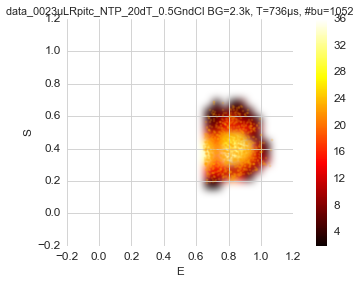

In [61]:
dplot(d_high_fret, hist2d_alex);

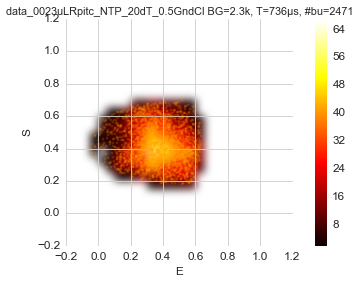

In [62]:
dplot(d_low_fret, hist2d_alex);

We can for example compute the ratio of high- and low-fret bursts:

In [63]:
1.*d_low_fret.num_bursts/d_high_fret.num_bursts

array([ 2.34885932])

##Burst Width analysis

To plot a burst-width histogram we can just use `hist_width` instead of `hist_fret`:

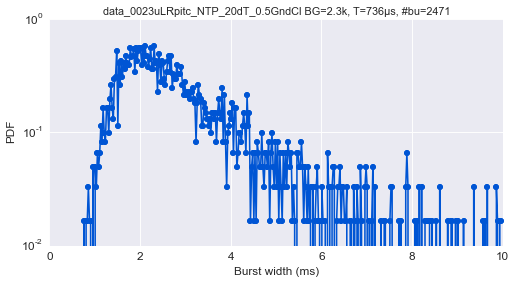

In [64]:
dplot(d_low_fret, hist_width)

Let use a larger bin size, plots two sub-populations (in different color) and add a legend:

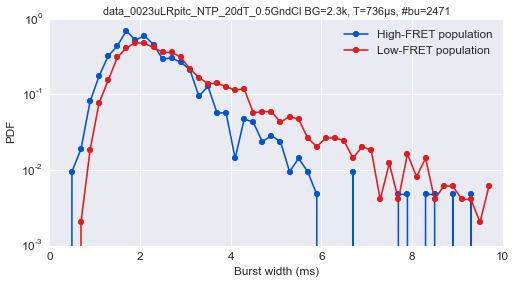

In [65]:
ax = dplot(d_high_fret, hist_width, bins=(0, 10, 0.2))
dplot(d_low_fret, hist_width, bins=(0, 10, 0.2), ax=ax)
plt.legend(['High-FRET population', 'Low-FRET population'])

Finally we compute the mean burst width for each subpopulation:

In [66]:
mean_b_width_low_fret  = bl.b_width(d_low_fret.mburst[0]).mean()*d_low_fret.clk_p*1e3
mean_b_width_high_fret = bl.b_width(d_high_fret.mburst[0]).mean()*d_high_fret.clk_p*1e3

print('Mean burst width: %.1f ms (high-fret), %.1f (low-fret)' % (mean_b_width_high_fret, mean_b_width_low_fret))

Mean burst width: 2.3 ms (high-fret), 3.0 (low-fret)


# FRET fit: in-depth example

We can fit a FRET distribution to any model. For example here we fit the FRET selection (2 FRET sub-population) with 2 gaussians. The model is a [`Model` object](http://lmfit.github.io/lmfit-py/model.html) from the [`lmfit` library](http://lmfit.github.io/lmfit-py/).

The first step, previously performed implicitely by the `hist_fret()` plot function, is creating a `MultiFitter` object for both $E$ and $S$. This is done calling `bext.burst_fitter()`. We can compute histogram, KDE and fit the histogram in one single step:

In [67]:
bext.bursts_fitter(d_fret_mix, 'E', binwidth=0.03, bandwidth=0.03, model=mfit.factory_two_gaussians())
bext.bursts_fitter(d_fret_mix, 'S', binwidth=0.03, bandwidth=0.03, model=mfit.factory_gaussian())

However if we want to modify the model (for example to add a constrain) we may want to perform the fit in a second step. To skip the fitting, we simply avoid passing a `model`:

In [68]:
bext.bursts_fitter(d_fret_mix, 'E', binwidth=0.03, bandwidth=0.03)
bext.bursts_fitter(d_fret_mix, 'S', binwidth=0.03, bandwidth=0.03) 

Now we create a model and initialize the parameters using `mfit.factory_two_gaussians()` (all the functions `mfit.factory_*` return initialized models):

In [69]:
model = mfit.factory_two_gaussians(add_bridge=True)

We can see the list of parameters, initial values and constraints:

In [70]:
model.param_hints

{'br_amplitude': {'min': 0, 'value': 0.0001},
 'br_center1': {'expr': 'p1_center', 'min': 0},
 'br_center2': {'expr': 'p2_center', 'min': 0},
 'br_sigma1': {'expr': 'p1_sigma', 'min': 0},
 'br_sigma2': {'expr': 'p2_sigma', 'min': 0},
 'p1_amplitude': {'min': 0.01, 'value': 1},
 'p1_center': {'max': 2, 'min': -1, 'value': 0.1},
 'p1_fwhm': {'expr': '2.3548200*p1_sigma'},
 'p1_sigma': {'max': 0.2, 'min': 0.01, 'value': 0.03},
 'p2_amplitude': {'min': 0.01, 'value': 1},
 'p2_center': {'max': 2, 'min': -1, 'value': 0.9},
 'p2_fwhm': {'expr': '2.3548200*p2_sigma'},
 'p2_sigma': {'max': 0.2, 'min': 0.01, 'value': 0.03}}

We can modify some initial values and contrains (bounds):

In [71]:
model.set_param_hint('p1_center', value=0.2, min=-0.1, max=0.6)
model.set_param_hint('p2_center', value=0.8, min=0.6, max=1.1)
model.param_hints

{'br_amplitude': {'min': 0, 'value': 0.0001},
 'br_center1': {'expr': 'p1_center', 'min': 0},
 'br_center2': {'expr': 'p2_center', 'min': 0},
 'br_sigma1': {'expr': 'p1_sigma', 'min': 0},
 'br_sigma2': {'expr': 'p2_sigma', 'min': 0},
 'p1_amplitude': {'min': 0.01, 'value': 1},
 'p1_center': {'max': 0.6, 'min': -0.1, 'value': 0.2},
 'p1_fwhm': {'expr': '2.3548200*p1_sigma'},
 'p1_sigma': {'max': 0.2, 'min': 0.01, 'value': 0.03},
 'p2_amplitude': {'min': 0.01, 'value': 1},
 'p2_center': {'max': 1.1, 'min': 0.6, 'value': 0.8},
 'p2_fwhm': {'expr': '2.3548200*p2_sigma'},
 'p2_sigma': {'max': 0.2, 'min': 0.01, 'value': 0.03}}

Finally we assign the model and we fit the histogram with one of the [supported minimization methods](http://lmfit.github.io/lmfit-py/fitting.html#fit-engines-label) (default is least-squares):

In [72]:
d_fret_mix.E_fitter.fit_histogram(model=model)       # The default method is 'leastsq'
#d_fret_mix.E_fitter.fit_histogram(model=model, method='nelder')

 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"


In the early examples we directly passed the model to fit_histogram. Here we first created the model, tweaked some initial values and constrains and then used this model to fit the $E$ histogram.

To plot the model with the fitted parameters on top of the FRET histogram we add `show_model=True` as seen before:

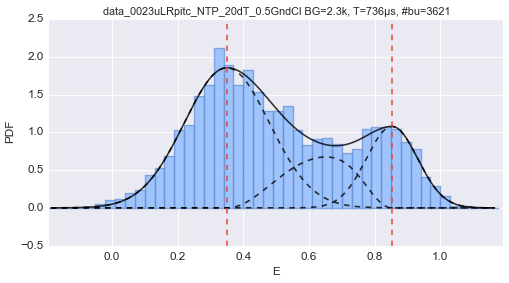

In [73]:
dplot(d_fret_mix, hist_fret, show_model=True)

The minimizer object returned by `lmfit` is saved in the list `fit_res` (one element per channel) in the fitter object:

In [74]:
results = d_fret_mix.E_fitter.fit_res[0]
results.best_values

{'br_amplitude': 0.75136370329236102,
 'br_center1': 0.35005250050104597,
 'br_center2': 0.85285913491025245,
 'br_sigma1': 0.12954970652151312,
 'br_sigma2': 0.077918609548801643,
 'p1_amplitude': 0.60211755936284672,
 'p1_center': 0.35005250050104597,
 'p1_sigma': 0.12954970652151312,
 'p2_amplitude': 0.21044485108877953,
 'p2_center': 0.85285913491025245,
 'p2_sigma': 0.077918609548801643}

For example we can take a look at the initial parameters:

In [75]:
results.init_params.values()

[<Parameter 'br_center2', 0, bounds=[0:inf], expr='p2_center'>,
 <Parameter 'br_center1', 0, bounds=[0:inf], expr='p1_center'>,
 <Parameter 'br_amplitude', 0.0001, bounds=[0:inf]>,
 <Parameter 'p1_center', 0.2, bounds=[-0.1:0.6]>,
 <Parameter 'p2_amplitude', 1, bounds=[0.01:inf]>,
 <Parameter 'p2_sigma', 0.03, bounds=[0.01:0.2]>,
 <Parameter 'br_sigma2', 0, bounds=[0:inf], expr='p2_sigma'>,
 <Parameter 'br_sigma1', 0, bounds=[0:inf], expr='p1_sigma'>,
 <Parameter 'p2_center', 0.8, bounds=[0.6:1.1]>,
 <Parameter 'p1_sigma', 0.03, bounds=[0.01:0.2]>,
 <Parameter 'p1_amplitude', 1, bounds=[0.01:inf]>,
 <Parameter 'p2_fwhm', None, bounds=[-inf:inf], expr='2.3548200*p2_sigma'>,
 <Parameter 'p1_fwhm', None, bounds=[-inf:inf], expr='2.3548200*p1_sigma'>]

and at the fitted parameters (with error ranges computed from the non-linear least squares algorithm):

In [76]:
results.params.values()

[<Parameter 'br_center2', value=0.85285913491025245 +/- 0.0111, bounds=[0:inf], expr='p2_center'>,
 <Parameter 'br_center1', value=0.35005250050104597 +/- 0.00609, bounds=[0:inf], expr='p1_center'>,
 <Parameter 'br_amplitude', value=0.75136370329236102 +/- 0.068, bounds=[0:inf]>,
 <Parameter 'p1_center', value=0.35005250050104597 +/- 0.00609, bounds=[-0.1:0.6]>,
 <Parameter 'p2_amplitude', value=0.21044485108877953 +/- 0.0249, bounds=[0.01:inf]>,
 <Parameter 'p2_sigma', value=0.077918609548801643 +/- 0.00935, bounds=[0.01:0.2]>,
 <Parameter 'br_sigma2', value=0.077918609548801643 +/- 0.00935, bounds=[0:inf], expr='p2_sigma'>,
 <Parameter 'br_sigma1', value=0.12954970652151312 +/- 0.00572, bounds=[0:inf], expr='p1_sigma'>,
 <Parameter 'p2_center', value=0.85285913491025245 +/- 0.0111, bounds=[0.6:1.1]>,
 <Parameter 'p1_sigma', value=0.12954970652151312 +/- 0.00572, bounds=[0.01:0.2]>,
 <Parameter 'p1_amplitude', value=0.60211755936284672 +/- 0.0241, bounds=[0.01:inf]>,
 <Parameter 'p2_f

Moreover, for convenience, the fitter object (`E_fitter`) saves the fitted parameter values in `E_fitter.params` (a pandas DataFrame):

In [77]:
d_fret_mix.E_fitter.params

,br_center2,br_center1,br_amplitude,p1_center,p2_amplitude,p2_sigma,br_sigma2,br_sigma1,p2_center,p1_sigma,p1_amplitude
0,0.8528591,0.3500525,0.7513637,0.3500525,0.2104449,0.07791861,0.07791861,0.1295497,0.8528591,0.1295497,0.6021176


Lmfit allows to print useful fit reports that include statistics like reduced chi-square, error ranges ($\pm 1 \sigma$) and correlations:

In [78]:
print(results.fit_report())

[[Model]]
    ((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(bridge_function, prefix='br_'))
[[Fit Statistics]]
    # function evals   = 132
    # data points      = 46
    # variables        = 7
    chi-square         = 0.323
    reduced chi-square = 0.008
[[Variables]]
    br_center2:     0.85285913 +/- 0.011066 (1.30%)  == 'p2_center'
    br_center1:     0.35005250 +/- 0.006089 (1.74%)  == 'p1_center'
    br_amplitude:   0.75136370 +/- 0.068039 (9.06%) (init= 0.0001)
    p1_center:      0.35005250 +/- 0.006089 (1.74%) (init= 0.2)
    p2_amplitude:   0.21044485 +/- 0.024874 (11.82%) (init= 1)
    p2_sigma:       0.07791860 +/- 0.009351 (12.00%) (init= 0.03)
    br_sigma2:      0.07791860 +/- 0.009351 (12.00%)  == 'p2_sigma'
    br_sigma1:      0.12954970 +/- 0.005720 (4.42%)  == 'p1_sigma'
    p2_center:      0.85285913 +/- 0.011066 (1.30%) (init= 0.8)
    p1_sigma:       0.12954970 +/- 0.005720 (4.42%) (init= 0.03)
    p1_amplitude:   0.60211755 +/- 0.02413

For more information on fitting features refer to the [lmfit documentation](http://cars9.uchicago.edu/software/python/lmfit/index.html).

# Timetrace and Ratetrace

For an intial inspection of a data file is common to do a *timetrace* plot. We also can do a similar plot called *ratetrace* that does not bin the data but shows the instantaneous rate. In both cases is convenient to scroll the plot interactively.

In FRETBursts we have *timetrace* and *ratetrace* plots that support interactive scrolling. We just need to switch from the inline backend to the QT, like we did before. 

And here the commands:

In [79]:
#%matplotlib qt

In [80]:
#dplot(ds, ratetrace, scroll=True, bursts=True)

In [81]:
#dplot(ds, timetrace, tmax=600, scroll=True, bursts=True)

In [82]:
#%matplotlib inline

# Notebook style

In [83]:
from IPython.core.display import HTML
HTML(open("./styles/custom2.css", "r").read())